# Simulating a Hodgkin-Huxley Type Thalamic Network with `braincell`

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chaobrain/brain-modeling-ecosystem/blob/develop/docs/braincell_HH_thalamus_oscillations.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/chaobrain/brain-modeling-ecosystem/blob/develop/docs/braincell_HH_thalamus_oscillations.ipynb)

This section introduces the simulation of a Hodgkin-Huxley type thalamic network using `braincell`.

As a practical example, before learning how to model a Hodgkin-Huxley type thalamic network with `braincell`, you should already be familiar with modeling a Hodgkin-Huxley type [E–I network](braincell_HH_network-zh.ipynb).

## Overview of the Thalamic Network

The thalamus plays a critical role in the generation of thalamocortical oscillations, yet the underlying mechanisms remain unclear. To explore whether the thalamus alone can generate multiple distinct oscillations, we construct a computational model.

Thalamic activity is modulated by various neurotransmitters, among which acetylcholine (ACh) and norepinephrine (NE) are key regulators that shape oscillatory dynamics.

The thalamic network model we build consists of two nuclei: the lateral geniculate nucleus (LGN) and the thalamic reticular nucleus (TRN). The LGN contains three types of neurons: high-threshold bursting thalamocortical cells (HTC), relay-mode thalamocortical cells (RTC), and local interneurons (IN). The TRN contains a single type of neuron: reticular cells (RE).

These different neuronal populations are interconnected through gap junctions and synapses. Under the modulation of ACh and NE, the network generates oscillations across four frequency bands: delta, spindle, alpha, and gamma.

## Thalamic Neuron Modeling

After understanding the connectivity structure of the thalamic network, we first model the thalamic neurons.

In [172]:
from typing import Dict, Callable

import time
import braincell
import brainstate
import brainpy.state
import braintools
import brainunit as u
import matplotlib.pyplot as plt
import numba
import numpy as np


brainstate.environ.set(dt=0.1 * u.ms)

First, we define a base class for thalamic neurons, which inherits from `SingleCompartment`.

In [173]:
class ThalamusNeuron(braincell.SingleCompartment):
    def compute_derivative(self, I_ext=0. * u.nA):
        I_ext = self.sum_current_inputs(I_ext, self.V.value) * self.area
        for key, ch in self.nodes(braincell.IonChannel, allowed_hierarchy=(1, 1)).items():
            I_ext = I_ext + ch.current(self.V.value)
        self.V.derivative = I_ext / self.C
        for key, node in self.nodes(braincell.IonChannel, allowed_hierarchy=(1, 1)).items():
            node.compute_derivative(self.V.value)

    def step_run(self, t, inp):
        with brainstate.environ.context(t=t):
            self.update(inp)
            return self.V.value

In this example, the thalamic neuron model differs from the [HH neuron in the E–I network](braincell_HH_neuron-zh.ipynb).
Here, the interface `compute_derivative` is explicitly defined to update the membrane potential dynamics.

This interface integrates external input currents with the ionic currents from all channel components, and then updates both the membrane potential and the derivatives of the ion channels. This corresponds to the standard differential equation update method for Hodgkin–Huxley type neurons.

Additionally, the method `step_run` is implemented to facilitate later simulation and visualization.


Next, we model the four different types of thalamic neurons.

Here, we take the HTC neuron as an example.

The HTC neuron inherits from the `ThalamusNeuron` class defined above and updates its membrane potential dynamics following the same procedure as `ThalamusNeuron`.

According to the reference, its membrane area is $2.9 \times 10^{-4} \ \text{cm}^2$.

In addition, the HTC neuron contains multiple types of ionic currents:

- a spike-generating fast sodium current ($I_\text{Na}$)
- a delayed rectifier potassium current ($I_\text{DR}$)
- a hyperpolarization-activated cation current ($I_\text{H}$)
- a high-threshold L-type Ca$^{2+}$ current ($I_{\text{Ca/L}}$)
- a Ca$^{2+}$-activated nonselective cation current ($I_\text{CAN}$)
- a regular low-threshold T-type Ca$^{2+}$ current ($I_{\text{Ca/T}}$)
- a high-threshold T-type Ca$^{2+}$ current ($I_{\text{Ca/HT}}$)
- a Ca$^{2+}$-dependent potassium current ($I_\text{AHP}$)
- a potassium leak current ($I_\text{KL}$)
- a leakage current ($I_\text{L}$)

We then add these ionic channels to the HTC model and specify their parameters according to the reference.

In [174]:
class HTC(ThalamusNeuron):
    def __init__(
        self,
        size,
        gKL=0.01 * (u.mS / u.cm ** 2),
        V_initializer=braintools.init.Constant(-65. * u.mV),
        solver: str = 'ind_exp_euler'
    ):
        super().__init__(size, V_initializer=V_initializer, V_th=20. * u.mV, solver=solver)

        self.area = 1e-3 / (2.9e-4 * u.cm ** 2)

        self.na = braincell.ion.SodiumFixed(size, E=50. * u.mV)
        self.na.add(INa=braincell.channel.INa_Ba2002(size, V_sh=-30 * u.mV))

        self.k = braincell.ion.PotassiumFixed(size, E=-90. * u.mV)
        self.k.add(IKL=braincell.channel.IK_Leak(size, g_max=gKL))
        self.k.add(IDR=braincell.channel.IKDR_Ba2002(size, V_sh=-30. * u.mV, phi=0.25))

        self.ca = braincell.ion.CalciumDetailed(size, C_rest=5e-5 * u.mM, tau=10. * u.ms, d=0.5 * u.um)
        self.ca.add(ICaL=braincell.channel.ICaL_IS2008(size, g_max=0.5 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaN=braincell.channel.ICaN_IS2008(size, g_max=0.5 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaT=braincell.channel.ICaT_HM1992(size, g_max=2.1 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaHT=braincell.channel.ICaHT_HM1992(size, g_max=3.0 * (u.mS / u.cm ** 2)))

        self.kca = braincell.MixIons(self.k, self.ca)
        self.kca.add(IAHP=braincell.channel.IAHP_De1994(size, g_max=0.3 * (u.mS / u.cm ** 2)))

        self.Ih = braincell.channel.Ih_HM1992(size, g_max=0.01 * (u.mS / u.cm ** 2), E=-43 * u.mV)
        self.IL = braincell.channel.IL(size, g_max=0.0075 * (u.mS / u.cm ** 2), E=-70 * u.mV)

Similarly, we model the RTC, IN, and TRN neurons.


In [175]:
class RTC(ThalamusNeuron):
    def __init__(
        self,
        size,
        gKL=0.01 * (u.mS / u.cm ** 2),
        V_initializer=braintools.init.Constant(-65. * u.mV),
        solver: str = 'ind_exp_euler'
    ):
        super().__init__(size, V_initializer=V_initializer, V_th=20 * u.mV, solver=solver)

        self.area = 1e-3 / (2.9e-4 * u.cm ** 2)

        self.na = braincell.ion.SodiumFixed(size)
        self.na.add(INa=braincell.channel.INa_Ba2002(size, V_sh=-40 * u.mV))

        self.k = braincell.ion.PotassiumFixed(size, E=-90. * u.mV)
        self.k.add(IDR=braincell.channel.IKDR_Ba2002(size, V_sh=-40 * u.mV, phi=0.25))
        self.k.add(IKL=braincell.channel.IK_Leak(size, g_max=gKL))

        self.ca = braincell.ion.CalciumDetailed(size, C_rest=5e-5 * u.mM, tau=10. * u.ms, d=0.5 * u.um)
        self.ca.add(ICaL=braincell.channel.ICaL_IS2008(size, g_max=0.3 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaN=braincell.channel.ICaN_IS2008(size, g_max=0.6 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaT=braincell.channel.ICaT_HM1992(size, g_max=2.1 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaHT=braincell.channel.ICaHT_HM1992(size, g_max=0.6 * (u.mS / u.cm ** 2)))

        self.kca = braincell.MixIons(self.k, self.ca)
        self.kca.add(IAHP=braincell.channel.IAHP_De1994(size, g_max=0.1 * (u.mS / u.cm ** 2)))

        self.Ih = braincell.channel.Ih_HM1992(size, g_max=0.01 * (u.mS / u.cm ** 2), E=-43 * u.mV)
        self.IL = braincell.channel.IL(size, g_max=0.0075 * (u.mS / u.cm ** 2), E=-70 * u.mV)

In [176]:
class IN(ThalamusNeuron):
    def __init__(
        self,
        size,
        gKL=0.01 * (u.mS / u.cm ** 2),
        V_initializer=braintools.init.Constant(-70. * u.mV),
        solver: str = 'ind_exp_euler'
    ):
        super().__init__(size, V_initializer=V_initializer, V_th=20. * u.mV, solver=solver)

        self.area = 1e-3 / (1.7e-4 * u.cm ** 2)

        self.na = braincell.ion.SodiumFixed(size)
        self.na.add(INa=braincell.channel.INa_Ba2002(size, V_sh=-30 * u.mV))

        self.k = braincell.ion.PotassiumFixed(size, E=-90. * u.mV)
        self.k.add(IDR=braincell.channel.IKDR_Ba2002(size, V_sh=-30 * u.mV, phi=0.25))
        self.k.add(IKL=braincell.channel.IK_Leak(size, g_max=gKL))

        self.ca = braincell.ion.CalciumDetailed(size, C_rest=5e-5 * u.mM, tau=10. * u.ms, d=0.5 * u.um)
        self.ca.add(ICaN=braincell.channel.ICaN_IS2008(size, g_max=0.1 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaHT=braincell.channel.ICaHT_HM1992(size, g_max=2.5 * (u.mS / u.cm ** 2)))

        self.kca = braincell.MixIons(self.k, self.ca)
        self.kca.add(IAHP=braincell.channel.IAHP_De1994(size, g_max=0.2 * (u.mS / u.cm ** 2)))

        self.IL = braincell.channel.IL(size, g_max=0.0075 * (u.mS / u.cm ** 2), E=-60 * u.mV)
        self.Ih = braincell.channel.Ih_HM1992(size, g_max=0.05 * (u.mS / u.cm ** 2), E=-43 * u.mV)

In [177]:
class TRN(ThalamusNeuron):
    def __init__(
        self,
        size,
        gKL=0.01 * (u.mS / u.cm ** 2),
        V_initializer=braintools.init.Constant(-70. * u.mV),
        gl=0.0075,
        solver: str = 'ind_exp_euler'
    ):
        super().__init__(size, V_initializer=V_initializer, V_th=20. * u.mV, solver=solver)

        self.area = 1e-3 / (1.43e-4 * u.cm ** 2)

        self.na = braincell.ion.SodiumFixed(size)
        self.na.add(INa=braincell.channel.INa_Ba2002(size, V_sh=-40 * u.mV))

        self.k = braincell.ion.PotassiumFixed(size, E=-90. * u.mV)
        self.k.add(IDR=braincell.channel.IKDR_Ba2002(size, V_sh=-40 * u.mV))
        self.k.add(IKL=braincell.channel.IK_Leak(size, g_max=gKL))

        self.ca = braincell.ion.CalciumDetailed(size, C_rest=5e-5 * u.mM, tau=100. * u.ms, d=0.5 * u.um)
        self.ca.add(ICaN=braincell.channel.ICaN_IS2008(size, g_max=0.2 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaT=braincell.channel.ICaT_HP1992(size, g_max=1.3 * (u.mS / u.cm ** 2)))

        self.kca = braincell.MixIons(self.k, self.ca)
        self.kca.add(IAHP=braincell.channel.IAHP_De1994(size, g_max=0.2 * (u.mS / u.cm ** 2)))

        # self.IL = braincell.channel.IL(size, g_max=0.01 * (u.mS / u.cm ** 2), E=-60 * u.mV)
        self.IL = braincell.channel.IL(size, g_max=gl * (u.mS / u.cm ** 2), E=-60 * u.mV)

After completing the neuron modeling, we simulate the constructed single neuron.
Here, we use the HTC neuron as an example.


Elapsed time: 1.4957 s


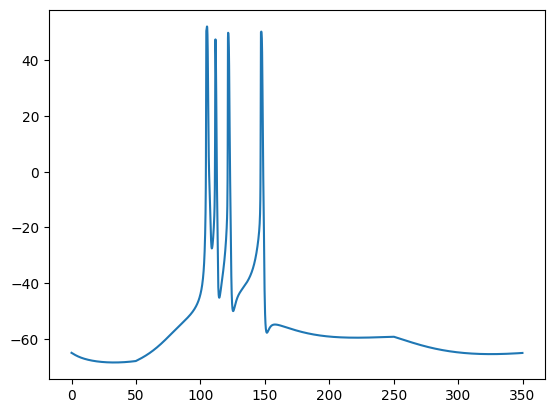

In [178]:
def try_neuron_simulation():
    brainstate.environ.set(dt=0.1 * u.ms)

    I = braintools.input.section(values=[0, 0.05, 0], durations=[50 * u.ms, 200 * u.ms, 100 * u.ms]) * u.uA
    times = u.math.arange(I.shape[0]) * brainstate.environ.get_dt()

    neu = HTC(1)
    neu.init_state()

    t0 = time.time()
    vs = brainstate.transform.for_loop(neu.step_run, times, I)
    t1 = time.time()
    print(f"Elapsed time: {t1 - t0:.4f} s")

    plt.plot(times.to_decimal(u.ms), u.math.squeeze(vs.to_decimal(u.mV)))
    plt.show()

if __name__ == '__main__':
    try_neuron_simulation()

## Thalamic Network Modeling

After modeling the individual neurons, we proceed to model the complete thalamic network.

Most common synaptic models in neuroscience are readily available in `braincell`.
However, in this example, we encounter a relatively uncommon NMDA synapse with magnesium block, which needs to be modeled manually.

The `MgBlock` class we define inherits from `SynOut`, indicating that it is a synaptic output model.

According to its equation:

$$I_{\text{NMDA}}(V) = \dfrac{g \, (E - V)}{1 + \exp \!\left( -\dfrac{V + 25}{12.5} \right)}$$

it can be easily implemented in the model.

In [179]:
class MgBlock(brainpy.state.SynOut):
    def __init__(self, E=0. * u.mV):
        super(MgBlock, self).__init__()
        self.E = E

    def update(self, conductance, potential):
        return conductance * (self.E - potential) / (1 + u.math.exp(-(potential / u.mV + 25) / 12.5))

In addition, since the gap junction connections in this example are based on spatial distance and probability, we define a `ProbDist` class.

The purpose of the `ProbDist` class is to generate a set of synaptic connections given the sizes of the presynaptic and postsynaptic neuron populations, following these rules:

- Only connect neurons whose spatial distance in the 2D plane does not exceed `dist`.
- Each neuron pair has a probability `prob` of being connected.
- Each presynaptic neuron has a probability `pre_ratio` of participating in the connection.
- The `include_self` parameter controls whether self-connections are allowed.

Based on these rules, we can model gap junctions in a detailed and precise manner during network construction.

In [180]:
class ProbDist:
    def __init__(self, dist=2., prob=0.3, pre_ratio=1.0, include_self=False):
        self.dist = dist

        @numba.njit
        def _pos2ind(pos, size):
            idx = 0
            for i, p in enumerate(pos):
                idx += p * np.prod(size[i + 1:])
            return idx

        @numba.njit
        def _connect_2d(pre_pos, pre_size, post_size):
            all_post_ids = []
            all_pre_ids = []
            if np.random.random() < pre_ratio:
                normalized_pos = np.zeros(2)
                for i in range(2):
                    pre_len = pre_size[i]
                    post_len = post_size[i]
                    normalized_pos[i] = pre_pos[i] * post_len / pre_len
                for i in range(post_size[0]):
                    for j in range(post_size[1]):
                        post_pos = np.asarray((i, j))
                        d = np.sqrt(np.sum(np.square(pre_pos - post_pos)))
                        if d <= dist:
                            if d == 0. and not include_self:
                                continue
                            if np.random.random() <= prob:
                                all_post_ids.append(_pos2ind(post_pos, post_size))
                                all_pre_ids.append(_pos2ind(pre_pos, pre_size))
            return all_pre_ids, all_post_ids  # Return filled part of the arrays

        self.connect = _connect_2d

    def __call__(self, pre_size, post_size):
        pre_size = np.asarray([pre_size[0] ** 0.5, pre_size[0] ** 0.5], dtype=int)
        post_size = np.asarray([post_size[0] ** 0.5, post_size[0] ** 0.5], dtype=int)
        connected_pres = []
        connected_posts = []
        pre_ids = np.meshgrid(*(np.arange(p) for p in pre_size), indexing='ij')
        pre_ids = tuple(
            [
                (np.moveaxis(p, 0, 1).flatten())
                if p.ndim > 1 else p.flatten()
                for p in pre_ids
            ]
        )
        size = np.prod(pre_size)

        for i in range(size):
            pre_pos = np.asarray([p[i] for p in pre_ids])
            pres, posts = self.connect(pre_pos, pre_size, post_size)
            connected_pres.extend(pres)
            connected_posts.extend(posts)
        return np.asarray(connected_pres), np.asarray(connected_posts)

In this thalamic network, neurons are arranged in proportionally distributed grids:

- 49 HTC neurons arranged in a $7 \times 7$ grid
- 144 RTC neurons arranged in a $12 \times 12$ grid
- 64 IN neurons arranged in an $8 \times 8$ grid
- 100 RE neurons arranged in a $10 \times 10$ grid

All neuronal populations are placed on a two-dimensional grid.

The network connectivity is illustrated as follows:

![Network Connectivity Structure](../_static/image/braincell_HH_thalamus_oscillations_structure.png)

Details:

![Annotations](../_static/image/braincell_HH_thalamus_oscillations_structure_2.png)

Noise in this example is implemented as Poisson input at 100 Hz, modeled as `noise2HTC`, `noise2RTC`, `noise2IN`, and `noise2RE`.

HTC and RE neurons have intrinsic gap junction connections, modeled as `gj_HTC` and `gj_RE`, while RTC neurons are also connected to HTC neurons via gap junctions, modeled as `gj_RTC2HTC`.

Synaptic currents mediated by AMPA receptors are modeled as `HTC2IN_ampa`, `HTC2RE_ampa`, and `RTC2RE_ampa`.

Synaptic currents mediated by NMDA receptors are modeled as `HTC2IN_nmda`, `HTC2RE_nmda`, and `RTC2RE_nmda`.

Synaptic currents mediated by GABA receptors are modeled as `IN2RTC`, `RE2RTC`, `RE2HTC`, `RE2IN`, and `RE2RE`.

Combining the relevant parameters from the reference, the resulting network model is as follows:


In [181]:
class Thalamus(brainstate.nn.Module):
    def __init__(
        self,
        g_input: Dict[str, float],
        g_KL: Dict[str, float],
        HTC_V_init: Callable = braintools.init.Constant(-65. * u.mV),
        RTC_V_init: Callable = braintools.init.Constant(-65. * u.mV),
        IN_V_init: Callable = braintools.init.Constant(-70. * u.mV),
        RE_V_init: Callable = braintools.init.Constant(-70. * u.mV),
    ):
        super(Thalamus, self).__init__()

        # populations
        self.HTC = HTC(7 * 7, gKL=g_KL['TC'], V_initializer=HTC_V_init)
        self.RTC = RTC(12 * 12, gKL=g_KL['TC'], V_initializer=RTC_V_init)
        self.RE = TRN(10 * 10, gKL=g_KL['RE'], V_initializer=IN_V_init)
        self.IN = IN(8 * 8, gKL=g_KL['IN'], V_initializer=RE_V_init)

        # noises
        self.noise2HTC = brainpy.state.AlignPostProj(
            brainpy.state.PoissonSpike(self.HTC.varshape, freqs=100 * u.Hz),
            comm=brainstate.nn.OneToOne(self.HTC.varshape, g_input['TC'], ),
            syn=brainpy.state.Expon.desc(self.HTC.varshape, tau=5. * u.ms),
            out=brainpy.state.COBA.desc(E=0. * u.mV),
            post=self.HTC,
        )
        self.noise2RTC = brainpy.state.AlignPostProj(
            brainpy.state.PoissonSpike(self.RTC.varshape, freqs=100 * u.Hz),
            comm=brainstate.nn.OneToOne(self.RTC.varshape, g_input['TC']),
            syn=brainpy.state.Expon.desc(self.RTC.varshape, tau=5. * u.ms),
            out=brainpy.state.COBA.desc(E=0. * u.mV),
            post=self.RTC,
        )
        self.noise2IN = brainpy.state.AlignPostProj(
            brainpy.state.PoissonSpike(self.IN.varshape, freqs=100 * u.Hz),
            comm=brainstate.nn.OneToOne(self.IN.varshape, g_input['IN']),
            syn=brainpy.state.Expon.desc(self.IN.varshape, tau=5. * u.ms),
            out=brainpy.state.COBA.desc(E=0. * u.mV),
            post=self.IN,
        )
        self.noise2RE = brainpy.state.AlignPostProj(
            brainpy.state.PoissonSpike(self.RE.varshape, freqs=100 * u.Hz),
            comm=brainstate.nn.OneToOne(self.RE.varshape, g_input['RE']),
            syn=brainpy.state.Expon.desc(self.RE.varshape, tau=5. * u.ms),
            out=brainpy.state.COBA.desc(E=0. * u.mV),
            post=self.RE,
        )

        # HTC cells were connected with gap junctions
        self.gj_HTC = brainpy.state.SymmetryGapJunction(
            self.HTC, 'V', conn=ProbDist(dist=2., prob=0.3), weight=1e-2 * u.siemens
        )

        # HTC provides feedforward excitation to INs
        self.HTC2IN_ampa = brainpy.state.CurrentProj(
            self.HTC.align_pre(
                brainpy.state.STD.desc(tau=700 * u.ms, U=0.07)
            ).align_pre(
                brainpy.state.AMPA(self.HTC.varshape, alpha=0.94 / (u.ms * u.mM), beta=0.18 / u.ms)
            ).prefetch('g'),
            comm=brainstate.nn.FixedNumConn(self.HTC.varshape, self.IN.varshape, 0.3, 6e-3),
            out=brainpy.state.COBA(E=0. * u.mV),
            post=self.IN,
        )
        self.HTC2IN_nmda = brainpy.state.CurrentProj(
            self.HTC.align_pre(
                brainpy.state.STD.desc(tau=700 * u.ms, U=0.07),
            ).align_pre(
                brainpy.state.AMPA(self.HTC.varshape, alpha=1.0 / (u.ms * u.mM), beta=0.0067 / u.ms)
            ).prefetch('g'),
            comm=brainstate.nn.FixedNumConn(self.HTC.varshape, self.IN.varshape, 0.3, 3e-3),
            out=MgBlock(),
            post=self.IN,
        )

        # INs delivered feedforward inhibition to RTC cells
        self.IN2RTC = brainpy.state.CurrentProj(
            self.IN.align_pre(
                brainpy.state.STD.desc(tau=700 * u.ms, U=0.07)
            ).align_pre(
                brainpy.state.GABAa(self.IN.varshape, alpha=10.5 / (u.ms * u.mM), beta=0.166 / u.ms)
            ).prefetch_delay('g', 2 * u.ms),
            comm=brainstate.nn.FixedNumConn(self.IN.varshape, self.RTC.varshape, 0.3, 3e-3),
            out=brainpy.state.COBA(E=-80. * u.mV),
            post=self.RTC,
        )

        # 20% RTC cells electrically connected with HTC cells
        self.gj_RTC2HTC = brainpy.state.SymmetryGapJunction(
            (self.RTC, self.HTC), 'V', conn=ProbDist(dist=2., prob=0.3, pre_ratio=0.2), weight=1 / 300 * u.mS
        )

        # Both HTC and RTC cells sent glutamatergic synapses to RE neurons, while
        # receiving GABAergic feedback inhibition from the RE population
        self.HTC2RE_ampa = brainpy.state.CurrentProj(
            self.HTC.align_pre(
                brainpy.state.STD.desc(tau=700 * u.ms, U=0.07)
            ).align_pre(
                brainpy.state.AMPA(self.HTC.varshape, alpha=0.94 / (u.ms * u.mM), beta=0.18 / u.ms)
            ).prefetch_delay('g', 2 * u.ms),
            comm=brainstate.nn.FixedNumConn(self.HTC.varshape, self.RE.varshape, 0.2, 4e-3),
            out=brainpy.state.COBA(E=0. * u.mV),
            post=self.RE,
        )
        self.RTC2RE_ampa = brainpy.state.CurrentProj(
            self.RTC.align_pre(
                brainpy.state.STD.desc(tau=700 * u.ms, U=0.07)
            ).align_pre(
                brainpy.state.AMPA(self.RTC.varshape, alpha=0.94 / (u.ms * u.mM), beta=0.18 / u.ms)
            ).prefetch_delay('g', 2 * u.ms),
            comm=brainstate.nn.FixedNumConn(self.RTC.varshape, self.RE.varshape, 0.2, 4e-3),
            out=brainpy.state.COBA(E=0. * u.mV),
            post=self.RE,
        )
        self.HTC2RE_nmda = brainpy.state.CurrentProj(
            self.HTC.align_pre(
                brainpy.state.STD.desc(tau=700 * u.ms, U=0.07)
            ).align_pre(
                brainpy.state.AMPA(self.HTC.varshape, alpha=1. / (u.ms * u.mM), beta=0.0067 / u.ms)
            ).prefetch_delay('g', 2 * u.ms),
            comm=brainstate.nn.FixedNumConn(self.HTC.varshape, self.RE.varshape, 0.2, 2e-3),
            out=MgBlock(),
            post=self.RE,
        )
        self.RTC2RE_nmda = brainpy.state.CurrentProj(
            self.RTC.align_pre(
                brainpy.state.STD.desc(tau=700 * u.ms, U=0.07)
            ).align_pre(
                brainpy.state.AMPA(self.RTC.varshape, alpha=1. / (u.ms * u.mM), beta=0.0067 / u.ms)
            ).prefetch_delay('g', 2 * u.ms),
            comm=brainstate.nn.FixedNumConn(self.RTC.varshape, self.RE.varshape, 0.2, 2e-3),
            out=MgBlock(),
            post=self.RE,
        )
        self.RE2HTC = brainpy.state.CurrentProj(
            self.RE.align_pre(
                brainpy.state.STD.desc(tau=700 * u.ms, U=0.07)
            ).align_pre(
                brainpy.state.GABAa(self.RE.varshape, alpha=10.5 / (u.ms * u.mM), beta=0.166 / u.ms)
            ).prefetch_delay('g', 2 * u.ms),
            comm=brainstate.nn.FixedNumConn(self.RE.varshape, self.HTC.varshape, 0.2, 3e-3),
            out=brainpy.state.COBA(E=-80. * u.mV),
            post=self.HTC,
        )
        self.RE2RTC = brainpy.state.CurrentProj(
            self.RE.align_pre(
                brainpy.state.STD.desc(tau=700 * u.ms, U=0.07)
            ).align_pre(
                brainpy.state.GABAa(self.RE.varshape, alpha=10.5 / (u.ms * u.mM), beta=0.166 / u.ms)
            ).prefetch_delay('g', 2 * u.ms),
            comm=brainstate.nn.FixedNumConn(self.RE.varshape, self.RTC.varshape, 0.2, 3e-3),
            out=brainpy.state.COBA(E=-80. * u.mV),
            post=self.RTC,
        )

        # RE neurons were connected with both gap junctions and GABAergic synapses
        self.gj_RE = brainpy.state.SymmetryGapJunction(
            self.RE, 'V', conn=ProbDist(dist=2., prob=0.3, pre_ratio=0.2), weight=1 / 300 * u.mS
        )
        self.RE2RE = brainpy.state.CurrentProj(
            self.RE.align_pre(
                brainpy.state.STD.desc(tau=700 * u.ms, U=0.07)
            ).align_pre(
                brainpy.state.GABAa(self.RE.varshape, alpha=10.5 / (u.ms * u.mM), beta=0.166 / u.ms)
            ).prefetch_delay('g', 2 * u.ms),
            comm=brainstate.nn.FixedNumConn(self.RE.varshape, self.RE.varshape, 0.2, 1e-3),
            out=brainpy.state.COBA(E=-70. * u.mV),
            post=self.RE,
        )

        # 10% RE neurons project GABAergic synapses to local interneurons
        # probability (0.05) was used for the RE->IN synapses according to experimental data
        self.RE2IN = brainpy.state.CurrentProj(
            self.RE.align_pre(
                brainpy.state.STD.desc(tau=700 * u.ms, U=0.07)
            ).align_pre(
                brainpy.state.GABAa(self.RE.varshape, alpha=10.5 / (u.ms * u.mM), beta=0.166 / u.ms)
            ).prefetch_delay('g', 2 * u.ms),
            comm=brainstate.nn.FixedNumConn(self.RE.varshape, self.IN.varshape, 0.05, 1e-3, afferent_ratio=0.1),
            out=brainpy.state.COBA(E=-80. * u.mV),
            post=self.IN,
        )

    def update(self, i, t, current):
        with brainstate.environ.context(t=t, i=i):
            self.noise2HTC()
            self.noise2RTC()
            self.noise2IN()
            self.noise2RE()

            self.HTC2IN_ampa()
            self.HTC2IN_nmda()

            self.IN2RTC()

            self.HTC2RE_ampa()
            self.RTC2RE_ampa()
            self.HTC2RE_nmda()
            self.RTC2RE_nmda()

            self.RE2HTC()
            self.RE2RTC()
            self.RE2RE()
            self.RE2IN()

            self.gj_HTC()
            self.gj_RTC2HTC()
            self.gj_RE()

            htc_spike = self.HTC(current)
            rtc_spike = self.RTC(current)
            re_spike = self.RE(current)
            in_spike = self.IN(current)

        return {
            'HTC.V': self.HTC.V.value,
            'RTC.V': self.RTC.V.value,
            'IN.V': self.IN.V.value,
            'RE.V': self.RE.V.value,
            'HTC.spike': htc_spike,
            'RTC.spike': rtc_spike,
            'RE.spike': re_spike,
            'IN.spike': in_spike,
        }

For this thalamic network, different parameters can generate oscillations at different frequencies.

The correspondence between the relevant parameters and oscillation frequencies is shown below:

![Parameter–Frequency Mapping](../_static/image/braincell_HH_thalamus_oscillations_parameters.png)

To facilitate simulation, we directly package these parameters as follows:

In [182]:
states = {
    'delta': dict(
        g_input={'IN': 1e-4 * u.mS, 'RE': 1e-4 * u.mS, 'TC': 1e-4 * u.mS},
        g_KL={'TC': 0.035 * u.mS / u.cm ** 2, 'RE': 0.03 * u.mS / u.cm ** 2, 'IN': 0.01 * u.mS / u.cm ** 2}
    ),
    'spindle': dict(
        g_input={'IN': 3e-4 * u.mS, 'RE': 3e-4 * u.mS, 'TC': 3e-4 * u.mS},
        g_KL={'TC': 0.01 * u.mS / u.cm ** 2, 'RE': 0.02 * u.mS / u.cm ** 2, 'IN': 0.015 * u.mS / u.cm ** 2}
    ),
    'alpha': dict(
        g_input={'IN': 1.5e-3 * u.mS, 'RE': 1.5e-3 * u.mS, 'TC': 1.5e-3 * u.mS},
        g_KL={'TC': 0. * u.mS / u.cm ** 2, 'RE': 0.01 * u.mS / u.cm ** 2, 'IN': 0.02 * u.mS / u.cm ** 2}
    ),
    'gamma': dict(
        g_input={'IN': 1.5e-3 * u.mS, 'RE': 1.5e-3 * u.mS, 'TC': 1.7e-2 * u.mS},
        g_KL={'TC': 0. * u.mS / u.cm ** 2, 'RE': 0.01 * u.mS / u.cm ** 2, 'IN': 0.02 * u.mS / u.cm ** 2}
    ),
}

To simulate periodic stimulation of neurons in the network, we define a function `rhythm_const_input`, which generates rhythmic square-wave current inputs.

In [183]:
def rhythm_const_input(amp, freq, length, duration, t_start=0., t_end=None, dt=None):
    if t_end is None:
        t_end = duration
    if length > duration:
        raise ValueError(f'Expected length <= duration, while we got {length} > {duration}')
    sec_length = 1 / freq
    values, durations = [0. * u.mA], [t_start]
    for t in u.math.arange(t_start, t_end, sec_length):
        values.append(amp)
        if t + length <= t_end:
            durations.append(length)
            values.append(0. * u.mA)
            if t + sec_length <= t_end:
                durations.append(sec_length - length)
            else:
                durations.append(t_end - t - length)
        else:
            durations.append(t_end - t)
    values.append(0. * u.mA)
    durations.append(duration - t_end)
    return braintools.input.section(values=values, durations=durations)

For convenient plotting, we encapsulate a small utility function to draw time-series curves.

In [184]:
def line_plot(ax, xs, ys, ylabel=None, xlim=None):
    ax.plot(xs, ys)
    ax.set_xlabel('Time (ms)')
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if xlim is not None:
        ax.set_xlim(xlim)

Similarly, we encapsulate a function to plot spike raster diagrams of neurons.

In [185]:
def raster_plot(
    ax, times, spikes, ylabel='Neuron Index', xlabel='Time [ms]',
    xlim=None, marker='.', markersize=2, color='k'
):
    elements = np.where(spikes > 0.)
    index = elements[1]
    time = times[elements[0]]
    ax.plot(time, index, marker + color, markersize=markersize)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if xlim:
        ax.set_xlim(xlim)

Simulate the network.

In [186]:
def try_network(state='delta'):
    net = Thalamus(
        IN_V_init=braintools.init.Constant(-70. * u.mV),
        RE_V_init=braintools.init.Constant(-70. * u.mV),
        HTC_V_init=braintools.init.Constant(-80. * u.mV),
        RTC_V_init=braintools.init.Constant(-80. * u.mV),
        **states[state],
    )
    brainstate.nn.init_all_states(net)

    duration = 3e3 * u.ms  # 3 seconds
    currents = rhythm_const_input(
        2e-4 * u.mA,
        freq=4. * u.Hz,
        length=10. * u.ms,
        duration=duration,
        t_end=2e3 * u.ms,
        t_start=1e3 * u.ms
    )
    indices = np.arange(currents.shape[0])
    times = indices * brainstate.environ.get_dt()
    mon = brainstate.transform.for_loop(net.update, indices, times, currents, pbar=200)

    fig, gs = braintools.visualize.get_figure(5, 2, 2, 5)
    line_plot(fig.add_subplot(gs[0, :]), times, currents, ylabel='Current', xlim=(0, duration / u.ms))
    line_plot(fig.add_subplot(gs[1, 0]), times, mon.get('HTC.V'), ylabel='HTC', xlim=(0, duration / u.ms))
    line_plot(fig.add_subplot(gs[2, 0]), times, mon.get('RTC.V'), ylabel='RTC', xlim=(0, duration / u.ms))
    line_plot(fig.add_subplot(gs[3, 0]), times, mon.get('IN.V'), ylabel='IN', xlim=(0, duration / u.ms))
    line_plot(fig.add_subplot(gs[4, 0]), times, mon.get('RE.V'), ylabel='RE', xlim=(0, duration / u.ms))
    raster_plot(fig.add_subplot(gs[1, 1]), times, mon.get('HTC.spike'), xlim=(0, duration / u.ms))
    raster_plot(fig.add_subplot(gs[2, 1]), times, mon.get('RTC.spike'), xlim=(0, duration / u.ms))
    raster_plot(fig.add_subplot(gs[3, 1]), times, mon.get('IN.spike'), xlim=(0, duration / u.ms))
    raster_plot(fig.add_subplot(gs[4, 1]), times, mon.get('RE.spike'), xlim=(0, duration / u.ms))
    plt.suptitle(f'Thalamus Network State: {state}')
    plt.show()

Here, we run the simulation using parameters that generate `alpha` and `gamma` oscillations as examples.

  0%|          | 0/30000 [00:00<?, ?it/s]

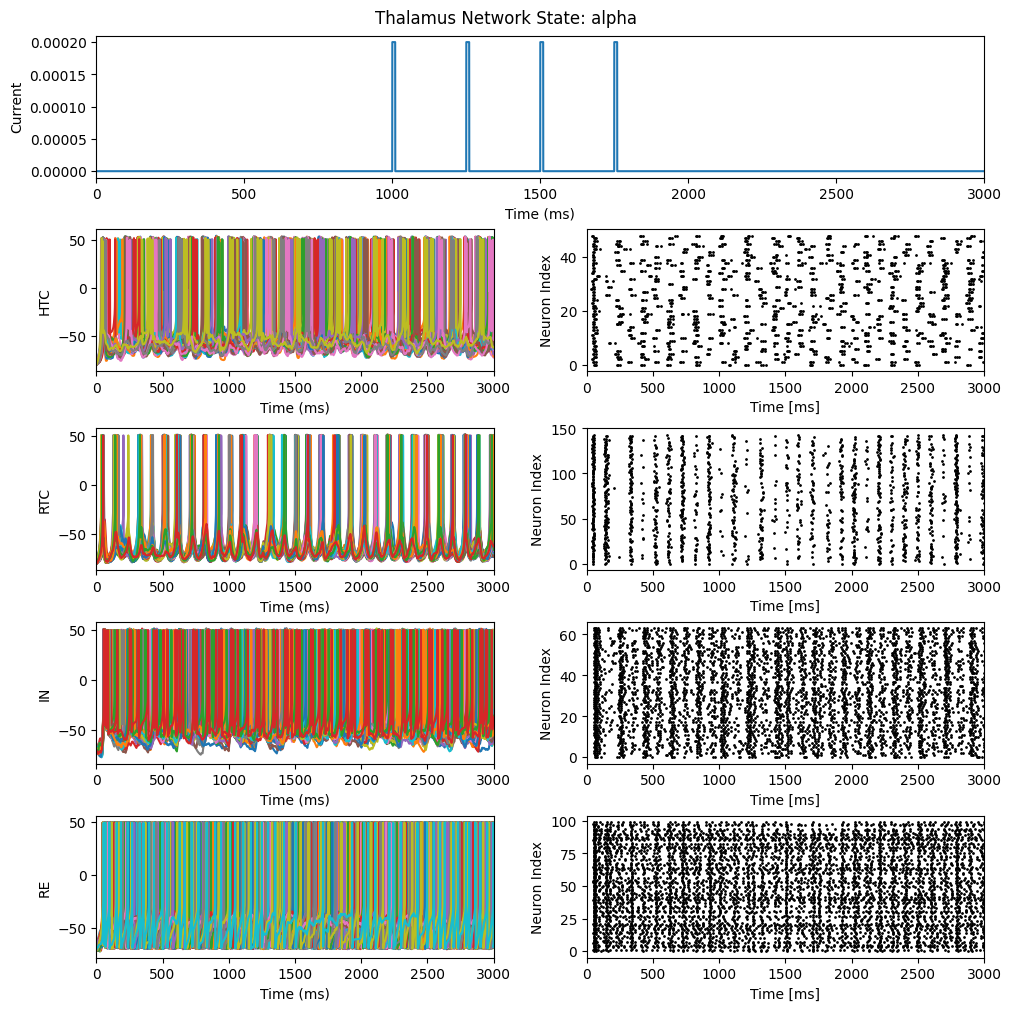

  0%|          | 0/30000 [00:00<?, ?it/s]

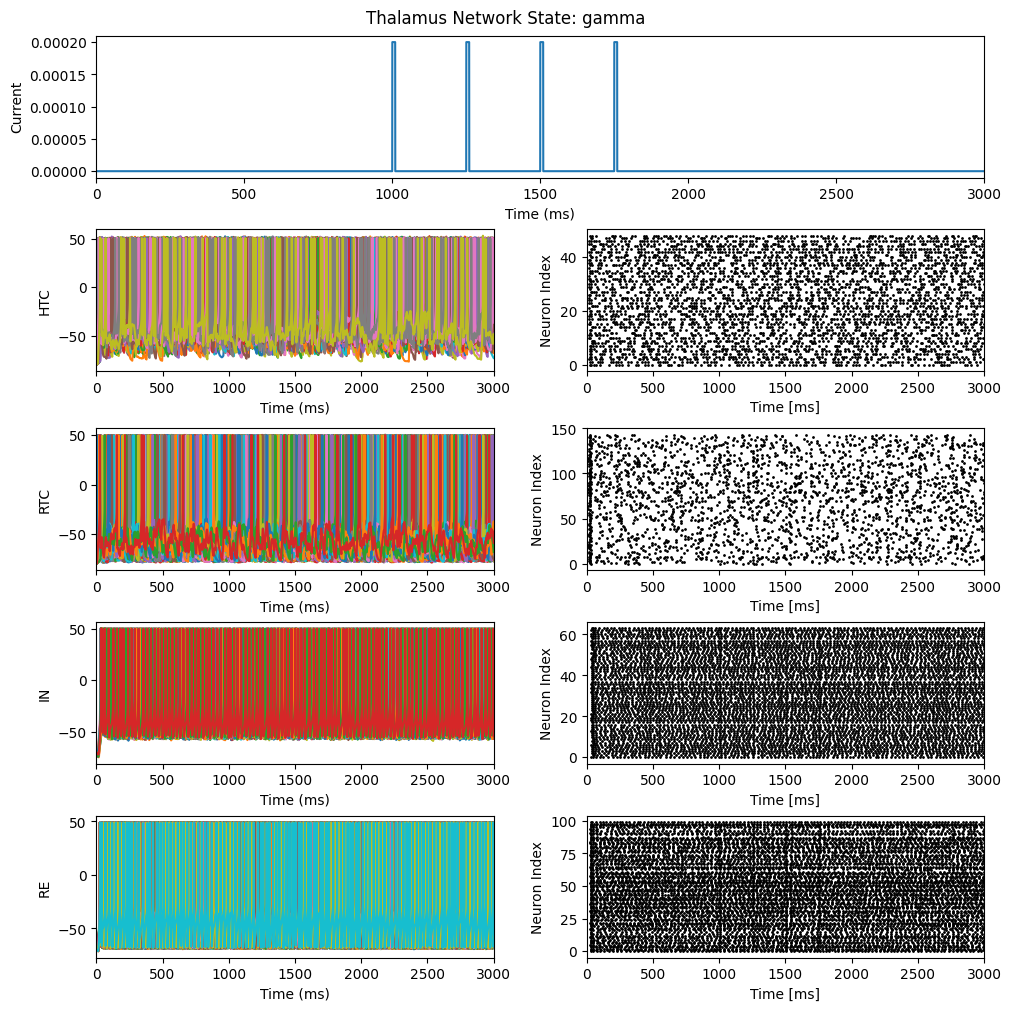

In [187]:
if __name__ == '__main__':
    try_network('alpha')
    try_network('gamma')

Observing the results, the constructed thalamic network model successfully exhibits the corresponding oscillatory rhythms.

The example models in this article are adapted from:

- G, Li., Henriquez, C. S., & Fröhlich, F. (2017), Unified thalamic model generates multiple distinct oscillations with state-dependent entrainment by stimulation., PLoS Comput. Biol., 13, 10, e1005797